In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import glob
from pathlib import Path
from types import SimpleNamespace

import scipy
import numpy as np
import torch
import open_clip
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from tqdm import tqdm
from torch.nn import functional as F
# from torch_geometric.nn.conv import GATv2Conv
from lavis.models.clip_models.loss import ClipLoss

from src.datasets import load_loader
from src.models import load_model
from src.utils import savgol_smooth
from src.imageloader import load_all_image_paths

%matplotlib inline

/opt/conda/envs/dlbasics/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /opt/conda/envs/dlbasics/lib/python3.10/site-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(


In [2]:
with open('../configs/config.yaml') as f:
    my_dict = yaml.safe_load(f)
args = SimpleNamespace(**my_dict)
args.clip = True

In [3]:
train_loader = load_loader("train", sg_filter=True, clip=True)
# val_loader = load_loader("val", sg_filter=True, clip=False)

In [4]:
X, y, _, img_f, text_f = next(iter(train_loader))

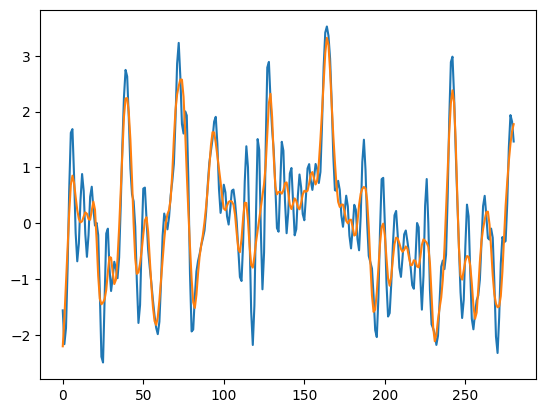

In [13]:
x_np = train_loader.dataset.X.to('cpu').detach().numpy()
x0 = x_np[3, 0, :]
x2 = savgol_smooth(x0, 11)
plt.plot(x0)
plt.plot(x2)

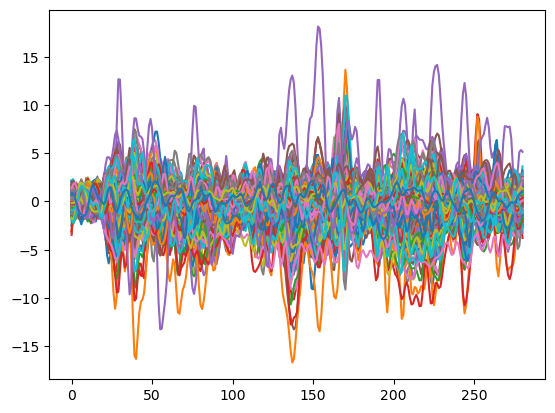

In [37]:
plt.plot(X[0][0:].T)
plt.show()

In [5]:
num_classes = train_loader.dataset.num_classes
seq_len = train_loader.dataset.seq_len
num_channels = train_loader.dataset.num_channels

model = load_model("CLIP_EEGNetv4", num_classes, num_channels, seq_len)
model = model.to("cuda")
X = X.to("cuda")
img_f = img_f.to("cuda")
text_f = text_f.to("cuda")

In [6]:
z, z2 = model(X)

In [15]:
logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
clip_loss = ClipLoss()

In [12]:
img_f.shape

torch.Size([128, 1024])

In [11]:
z.shape

torch.Size([128, 1024])

In [18]:
img_loss = clip_loss(z, img_f, logit_scale)
text_loss = clip_loss(z, text_f, logit_scale)
alpha = 0.5
clip_loss = alpha * img_loss + (1 - alpha) * text_loss

# to make pre encoded MEG features (text, images)

In [47]:
device = "cuda:0"
model_type = 'ViT-H-14'
vlmodel, preprocess_train, feature_extractor = open_clip.create_model_and_transforms(
    model_type, pretrained='laion2b_s32b_b79k', precision='fp32', device=device)

open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [142]:
path_df_x, texts_x = load_all_image_paths()
image_features_list = []
for batch in tqdm(batch_paths):
    image_inputs = torch.stack([preprocess_train(Image.open(img).convert("RGB")) for img in batch]).to(device)
    with torch.no_grad():
        batch_image_features = vlmodel.encode_image(image_inputs)
    image_features_list.append(batch_image_features)
image_features = torch.cat(image_features_list, dim=0)

texts = list(path_df["name"].unique())
tokenizer = open_clip.get_tokenizer('ViT-H-14')
text_inputs = torch.cat([tokenizer(f"a photo of {t}") for t in texts]).to(device)
with torch.no_grad():
    text_features = vlmodel.encode_text(text_inputs)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1306/1306 [14:29<00:00,  1.50it/s]


In [10]:
data_dir = Path("/notebooks/DockerShared/tracked/dl_lecture_competition_pub/data")

In [174]:
torch.save({
    "text_features": text_features.cpu(),
    "img_features": image_features.cpu()
}, data_dir / "precoded_features.pt")

train_image_paths = load_image_paths(train_loader.dataset, mode="train")
val_image_paths = load_image_paths(val_loader.dataset, mode="val")
train_image_paths = train_image_paths.merge(path_df, how="left")
val_image_paths = val_image_paths.merge(path_df, how="left")

train_image_features = image_features[list(train_image_paths["jpg_id"]), :]
train_text_features = text_features[list(train_image_paths["name_id"]), :]
torch.save({
    "text_features": train_text_features.cpu(),
    "img_features": train_image_features.cpu()
}, data_dir / "train_precoded_features.pt")

val_image_features = image_features[list(val_image_paths["jpg_id"]), :]
val_text_features = text_features[list(val_image_paths["name_id"]), :]
torch.save({
    "text_features": val_text_features.cpu(),
    "img_features": val_image_features.cpu()
}, data_dir / "val_precoded_features.pt")

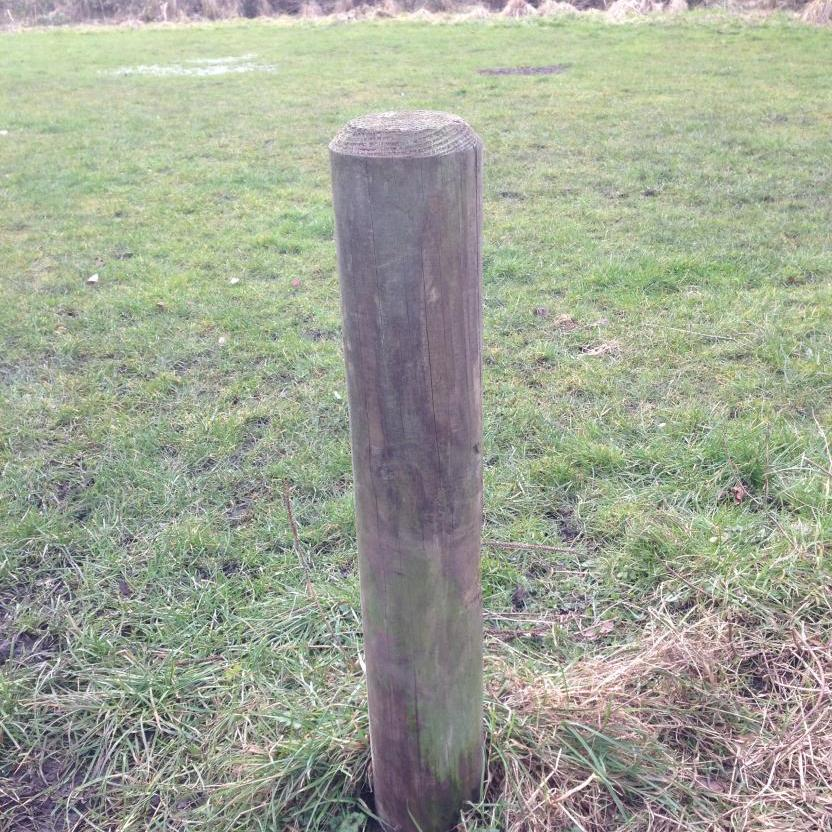

In [73]:
from PIL import Image
im = Image.open("../data/Images/fencepost/fencepost_09s.jpg")
im.show()